### Importing packages 

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 

## **Section 1: Cleaning the Data** 
### 1.1 Importing data 

In [3]:
hbsc_data = pd.read_csv("HBSC2018OAed1.csv") 
hbsc_data.head() 

/var/folders/2s/wm7f2gbs68g8ym75ybdx9r0c0000gn/T/ipykernel_15878/4246269913.py:1: DtypeWarning: Columns (11,13,14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  hbsc_data = pd.read_csv("HBSC2018OAed1.csv")


,HBSC,seqno_int,cluster,countryno,region,id1,id2,id3,id4,weight,...,talkstepmo,famhelp,famsup,famtalk,famdec,MBMI,IRFAS,IRRELFAS_LMH,IOTF4,oweight_who
0,2018,100001,100231,8000,AL,10,58,231,321,1.0,...,5,7,6,7,5,17.981667470725,6,2,1.79769313486232e+308,1.79769313486232e+308
1,2018,100002,100238,8000,AL,10,60,238,611,1.0,...,5,7,7,7,7,17.7832495468691,1.79769313486232e+308,1.79769313486232e+308,1.79769313486232e+308,1.79769313486232e+308
2,2018,100004,100066,8000,AL,3,16,66,1225,1.0,...,5,7,7,1,7,24.2439184746877,1.79769313486232e+308,1.79769313486232e+308,1.79769313486232e+308,1.79769313486232e+308
3,2018,100005,100047,8000,AL,3,14,47,1371,1.0,...,5,7,7,7,7,15.0310509869072,1.79769313486232e+308,1.79769313486232e+308,1.79769313486232e+308,1.79769313486232e+308
4,2018,100007,100132,8000,AL,5,30,132,1604,1.0,...,5,2,1,1,1,15.5709342560554,1.79769313486232e+308,1.79769313486232e+308,1.79769313486232e+308,1.79769313486232e+308


In [4]:
hbsc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244097 entries, 0 to 244096
Columns: 120 entries, HBSC to oweight_who
dtypes: float64(1), int64(10), object(109)
memory usage: 223.5+ MB


### 1.2 Filtering for our countries of interest
The Boniel-Nissim et al., 2023 study only analyzed 18 out of the 48 total countries that partook in the study. This is because
only these 18 countries answered questions regarding the sleep questionnaire. Under the methods section, subsection "Data and participants" the following 18 countries are listed with their accompanying sample sizes. **Note**: The study uses "Republic of Moldova" while the table shows "Moldova". This has been done to simplify renaming of countries from ID number to country name later): 

Country            | Sample Size 
:-------------------:|:--------------------:
Flemish Belgium    | 3761 
French Belgium     | 3285
Canada             | 9122
Czech Republic     | 10,612
Denmark            | 2823 
Estonia            | 4461 
Finland            | 2899
Greece             | 3633 
Hungary            | 3561 
Iceland            | 6198 
Latvia             | 3985 
Netherlands        | 4540 
Norway             | 2572 
Poland             | 4828 
Portugal           | 5413 
Moldova            | 4325 
Scotland           | 4541
Ukraine            | 5983 

We will filter the rows under the `countryno` column to only contain these countries.  

In [5]:
country_dict = {56001 : "Flemish Belgium", 56002: "French Belgium",124000: "Canada", 
                203000: "Czech Republic", 208000: "Denmark", 233000: "Estonia", 
                246000: "Finland", 300000: "Greece", 348000: "Hungary",
                352000: "Iceland", 428000: "Latvia", 528000: "Netherlands",
                578000: "Norway", 616000: "Poland", 620000: "Portugual",  
                498000: "Maldova", 826002: "Scotland", 804000: "Ukraine" 
                } 

def filter_country_ids(countries: dict) -> list:
    """
    Takes a dictionary with country ID numbers as keys and names as values and compiles a list of all the keys to make filtering 
    rows by the specific keys easier. 
    """
    country_ids = []
    for key in countries:
        country_ids.append(key) 
    return country_ids 
    
relevant_country_ids = filter_country_ids(country_dict) 

#Filtering for the 18 relevant countries in hbsc dataset 
hbsc_data = hbsc_data.loc[hbsc_data["countryno"].isin(relevant_country_ids)]
hbsc_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100079 entries, 53 to 244089
Columns: 120 entries, HBSC to oweight_who
dtypes: float64(1), int64(10), object(109)
memory usage: 92.4+ MB


In [6]:
#Renaming values in the countryno column from country ID to country name 

def obtain_country_names(countries: dict) -> list: 
    """
    Takes a dictionary with country ID numbers as keys and names as values and compiles a list of all the values to allow 
    us to identify countries by their names as opposed to their ID's.
    """
    country_names = []
    for key, value in countries.items(): 
        country_names.append(value) 
    return country_names 

relevant_country_names = obtain_country_names(country_dict) 

#Converting names and counting number of occurances 
hbsc_data = hbsc_data.replace(relevant_country_ids, relevant_country_names) 
counts = hbsc_data["countryno"].value_counts()
counts

countryno
Canada             12950
Czech Republic     11564
Iceland             6996
Ukraine             6660
Portugual           6126
French Belgium      5578
Poland              5224
Scotland            5021
Estonia             4725
Netherlands         4698
Maldova             4686
Latvia              4412
Flemish Belgium     4333
Greece              3863
Hungary             3789
Denmark             3181
Finland             3146
Norway              3127
Name: count, dtype: int64

### 1.3 Further data filteration 
The values above from the filtered dataset do not match the values provided in the paper. We must further filter out no-response
values to try and get values as similar to Boniel-Nissim et al., 2023 study. In particular, we have to get rid of no-response 
values for the Social Media Use questions. In the dataset no-repsonse is indicated either by a value of 99 or 1.79769313486232e+308. The following colunms will be filtered to exclude these values. 

- emconlfreq1  
- emconlfreq2
- emconlfreq3 
- emconlfreq4 
- emconlpref1
- emconlpref2
- emconlpref3
- emcsocmed1
- emcsocmed2
- emcsocmed3
- emcsocmed4
- emcsocmed5
- emcsocmed5
- emcsocmed6
- emcsocmed7
- emcsocmed8
- emcsocmed9

In [38]:
#Converstion of data from string to numeric float. Converts  1.79769313486232e+308 to NaN
hbsc_data["sleepdificulty"] = pd.to_numeric(hbsc_data["sleepdificulty"], errors='coerce')
hbsc_data["emconlfreq1"] = pd.to_numeric(hbsc_data["emconlfreq1"], errors='coerce')
hbsc_data["emconlfreq2"] = pd.to_numeric(hbsc_data["emconlfreq2"], errors='coerce')
hbsc_data["emconlfreq3"] = pd.to_numeric(hbsc_data["emconlfreq3"], errors='coerce')
hbsc_data["emconlfreq4"] = pd.to_numeric(hbsc_data["emconlfreq4"], errors='coerce')
hbsc_data["emconlpref1"] = pd.to_numeric(hbsc_data["emconlpref1"], errors='coerce')
hbsc_data["emconlpref2"] = pd.to_numeric(hbsc_data["emconlpref2"], errors='coerce')
hbsc_data["emconlpref3"] = pd.to_numeric(hbsc_data["emconlpref3"], errors='coerce')
hbsc_data["emcsocmed1"] = pd.to_numeric(hbsc_data["emcsocmed1"], errors='coerce')
hbsc_data["emcsocmed2"] = pd.to_numeric(hbsc_data["emcsocmed2"], errors='coerce')
hbsc_data["emcsocmed3"] = pd.to_numeric(hbsc_data["emcsocmed3"], errors='coerce')
hbsc_data["emcsocmed4"] = pd.to_numeric(hbsc_data["emcsocmed4"], errors='coerce')
hbsc_data["emcsocmed5"] = pd.to_numeric(hbsc_data["emcsocmed5"], errors='coerce')
hbsc_data["emcsocmed6"] = pd.to_numeric(hbsc_data["emcsocmed6"], errors='coerce')
hbsc_data["emcsocmed7"] = pd.to_numeric(hbsc_data["emcsocmed7"], errors='coerce')
hbsc_data["emcsocmed8"] = pd.to_numeric(hbsc_data["emcsocmed8"], errors='coerce')
hbsc_data["emcsocmed9"] = pd.to_numeric(hbsc_data["emcsocmed9"], errors='coerce')


#WHat the  actual fuck cant get rid of 1.79769313486232e+308 in emconlpref123 

# Define the columns where you want to replace values
# columns_to_replace = ["emconpref1", "emconpref2", "emconpref3"]

# # Convert the specified columns to numeric type if they are not already numeric
# hbsc_data[columns_to_replace] = hbsc_data[columns_to_replace].apply(pd.to_numeric, errors='coerce')

# # Replace values between 1 and 2 with NaN
# hbsc_data[columns_to_replace] = hbsc_data[columns_to_replace].mask((hbsc_data[columns_to_replace] > 1) 
#                                                                    & (hbsc_data[columns_to_replace] < 2), np.nan)

# column_list = ["sleepdificulty", "emconlfreq1", "emconlfreq2", "emconlfreq3", 
#                "emcsocmed1", "emcsocmed2", "emcsocmed3", "emcsocmed4", "emcsocmed5", 
#                "emcsocmed6", "emcsocmed7", "emcsocmed8", "emcsocmed9"]

# def convert_to_numeric(dataframe, columns: list[str]) -> list: 
#     for col_name in columns: 
#         dataframe[col_name] = pd.to_numeric(dataframe[col_name], errors = "coerce")

# convert_to_numeric(hbsc_data, column_list) 

#Applying indexing to column names 
column_mapping = [f"{x[0]}:{x[1]}" for x in enumerate(hbsc_data.columns)]

# We need to select columns 3, 33, 74-89
selected_columns_dataframe = hbsc_data.iloc[:, np.r_[3, 33, 74:90]]

#Removing all 99 and NaN rows  
hbsc_data_filtered = selected_columns_dataframe[
    (~selected_columns_dataframe.isin([99, np.nan])).all(axis=1) ]

hbsc_data_filtered.head()  

,countryno,sleepdificulty,emconlfreq1,emconlfreq2,emconlfreq3,emconlfreq4,emconlpref1,emconlpref2,emconlpref3,emcsocmed1,emcsocmed2,emcsocmed3,emcsocmed4,emcsocmed5,emcsocmed6,emcsocmed7,emcsocmed8,emcsocmed9
53,Canada,5.0,4.0,4.0,1.0,4.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
55,Canada,2.0,4.0,1.0,1.0,2.0,5.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
56,Canada,5.0,3.0,2.0,2.0,3.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
57,Canada,2.0,4.0,4.0,3.0,2.0,3.0,2.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
58,Canada,5.0,6.0,6.0,6.0,6.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [27]:
#Obtaining sample size counts for each country 
country_count = hbsc_data_filtered["countryno"].value_counts() 
country_count

countryno
Czech Republic     9517
Canada             8553
Iceland            5834
Ukraine            5717
Portugual          5410
Poland             4615
Netherlands        4448
Estonia            4254
French Belgium     4250
Scotland           4116
Maldova            3882
Latvia             3701
Flemish Belgium    3501
Greece             3438
Hungary            3310
Finland            2744
Denmark            2697
Norway             2240
Name: count, dtype: int64

### 1.4 Data Proportionality 
When comparing the count above to the count given in the Boniel-Nissim et al., 2023 study we can see that 
our values are smaller. This was to be expected as certain sleep data is unavailable to us through the 
given HBSC csv file. Thus, we will measure the proportionality of our data to see if it is a close match to the porportionality used in the study. 

In [28]:
#Proportion from our filtered dataframe 
#First Convert value counts into a dataframe
country_count = hbsc_data_filtered["countryno"].value_counts().reset_index().rename(
                columns={"index": "value", 0: "count"}) 
country_count.head() 

,countryno,count
0,Czech Republic,9517
1,Canada,8553
2,Iceland,5834
3,Ukraine,5717
4,Portugual,5410


In [29]:
#Calculate proportions and add new column
filtered_proportions = country_count.assign(our_prop = country_count['count'] / sum(country_count['count']))
filtered_proportions = round(filtered_proportions, 3)
filtered_proportions.head() 

,countryno,count,our_prop
0,Czech Republic,9517,0.116
1,Canada,8553,0.104
2,Iceland,5834,0.071
3,Ukraine,5717,0.070
4,Portugual,5410,0.066


In [30]:
#Proportion from the studies dataset
#First Create a dictionary that we can convert into a dataframe
study_countries_dict = {"Czech Republic" : 10612, "Canada": 9122, "Iceland": 6198, "Ukraine": 5983,
                        "Portugal": 5413, "Poland": 4828, "Netherlands": 4540, "French Belgium": 3285 ,
                        "Estonia": 4461, "Scotland": 4541, "Maldova": 4325, "Latvia": 3985, 
                        "Flemish Belgium": 3761, "Greece": 3633, "Hungary": 3561, "Finland": 2899, 
                        "Denmark": 2823, "Norway": 2572} 
#Creation of dataframe from dictionary 
study_dataframe = pd.DataFrame(list(study_countries_dict.items()), columns=['country', 'count'])
study_dataframe.head() 

,country,count
0,Czech Republic,10612
1,Canada,9122
2,Iceland,6198
3,Ukraine,5983
4,Portugal,5413


In [31]:
study_proportions = study_dataframe.assign(study_prop = study_dataframe['count'] / sum(study_dataframe['count']))
study_proportions = round(study_proportions, 3)
study_proportions.head() 

,country,count,study_prop
0,Czech Republic,10612,0.123
1,Canada,9122,0.105
2,Iceland,6198,0.072
3,Ukraine,5983,0.069
4,Portugal,5413,0.063


### Side by side comparison of proportions 

In [32]:
proportions_df = pd.concat([filtered_proportions , study_proportions], axis = 1) 
proportions_df = proportions_df[["countryno", "our_prop", "study_prop"]] 
proportions_df = proportions_df.assign(diff = proportions_df["our_prop"] - proportions_df["study_prop"]) 
proportions_df 

,countryno,our_prop,study_prop,diff
0,Czech Republic,0.116,0.123,-0.007
1,Canada,0.104,0.105,-0.001
2,Iceland,0.071,0.072,-0.001
3,Ukraine,0.070,0.069,0.001
4,Portugual,0.066,0.063,0.003
5,Poland,0.056,0.056,0.000
6,Netherlands,0.054,0.052,0.002
7,Estonia,0.052,0.038,0.014
8,French Belgium,0.052,0.052,0.000
9,Scotland,0.050,0.052,-0.002


As we see above when comparing the proportionality of sample sizes from each country between the data we filtered and the data used by the study we have achieved very similar values. The differences in proportionalities are minimal, so we can assume we are using a similar dataset as the researchers in the study. **TO ADD: Hypothesis Test Backing** 

## **Section 2: Visualizing the Data** 
### 2.1 Column and Value interpretations  

The names of the columns in the data set are identifiers for various social media use questions. The table below shows the question pertaining to the column name.... 

Column name     | Question
:----------------:|--------------------------------
emconlfreq1     | How often do you have ONLINE contact with close friends?
emconlfreq2     | How often do you have ONLINE contact with people in your larger friend group? 
emconlfreq3     | How often do you have ONLINE contact with online friends? 
emconlfreq4     | How often do you have ONLINE contact with other people, who dont fall into the above categories? 
emconlpref1     | How  much do you agree with the following statement? "On the internet, I talk more easily about secrets than in a face-to-face encounter" 
emconlpref2     | How  much do you agree with the following statement? "On the internet, I talk more easily about my inner feelings than in a face-to-face encounter" 
emconlpref3     | How  much do you agree with the following statement? "On the internet, I talk more easily about my concerns than in a face-to-face encounter"
emcsocmed1      | Answer yes or no to the following statement: Have you regularly found that you can’t think of anything else but the moment that you will be able to use social media again?
emcsocmed2      | Answer yes or no to the following statement: Have you regularly felt dissatisfied because you wanted to spend more time on social media?
emcsocmed3      | Answer yes or no to the following statement: Have you often felt bad when you could not use social media?
emcsocmed4      | Answer yes or no to the following statement: Have you tried to spend less time on social media, but failed?
emcsocmed5      | Answer yes or no to the following statement: Have you regularly neglected other activities (e.g. hobbies, sport) because you wanted to use social media?
emcsocmed6      | Answer yes or no to the following statement: Have you regularly had arguments with others because of your social media use?
emcsocmed7      | Answer yes or no to the following statement: Have you regularly lied to your parents or friends about the amount of time you spend on social media?
emcsocmed8      | Answer yes or no to the following statement: Have you often used social media to escape from negative feelings?
emcsocmed9      | Answer yes or no to the following statement: Have you had serious conflict with your parents, brother(s) or sister(s) because of your social media use?

**Answer choices for emconlfreq1 through emconlfreq4...** 

Answer Statement shown to participants     | Numerical value 
:-------------------------------------------:|:-----------------:
Dont Know / NA       | 1
Never/Almost never   | 2
Every week           | 3
Daily                | 4
Several times daily  | 5
Almost all the time  | 6

**Answer choices for emconlpref1 through emconlpref3...**

Answer Statement shown to participants     | Numerical value 
:-------------------------------------------:|:-----------------:
Strongly Disagree       | 1
Disagree                | 2
Neither/nor             | 3
Agree                   | 4
Strongly Agree          | 5

**Answer choices for emcsocmed1 through emcsocmed9...**

Answer Statement shown to participants     | Numerical value 
:-------------------------------------------:|:-----------------:
No       | 1
Yes      | 2


### 2.2 Visualizing emconlfreq data 

In [33]:
#Selecting the emconlfreq columns and change names
emconlfreq_data = hbsc_data_filtered[["emconlfreq1", "emconlfreq2", "emconlfreq3", "emconlfreq4"]]
emconlfreq_data = emconlfreq_data.rename(columns = {"emconlfreq1": "Close friends", 
                                                    "emconlfreq2": "Larger friend group",
                                                    "emconlfreq3": "Online friends",
                                                    "emconlfreq4": "Others"} ) 

replace_values = {1.0: "Dont know", 2.0: "Never/Almost never", 3.0: "Every week",
                  4.0: "Daily", 5.0: "Several times daily", 6.0: "Almost all the time"}

# Restructuring dataframe to make it easier to graph 
tidy_emconlfreq_data = emconlfreq_data.reset_index(drop = True) 
tidy_emconlfreq_data = emconlfreq_data.melt(var_name = "question", value_name = "response") 
tidy_emconlfreq_data["response"] = tidy_emconlfreq_data["response"].replace(replace_values) 

tidy_emconlfreq_data["response"] = pd.Categorical(tidy_emconlfreq_data["response"], categories = replace_values.values(), ordered=True)

tidy_emconlfreq_data.head() 

,question,response
0,Close friends,Daily
1,Close friends,Daily
2,Close friends,Every week
3,Close friends,Daily
4,Close friends,Almost all the time


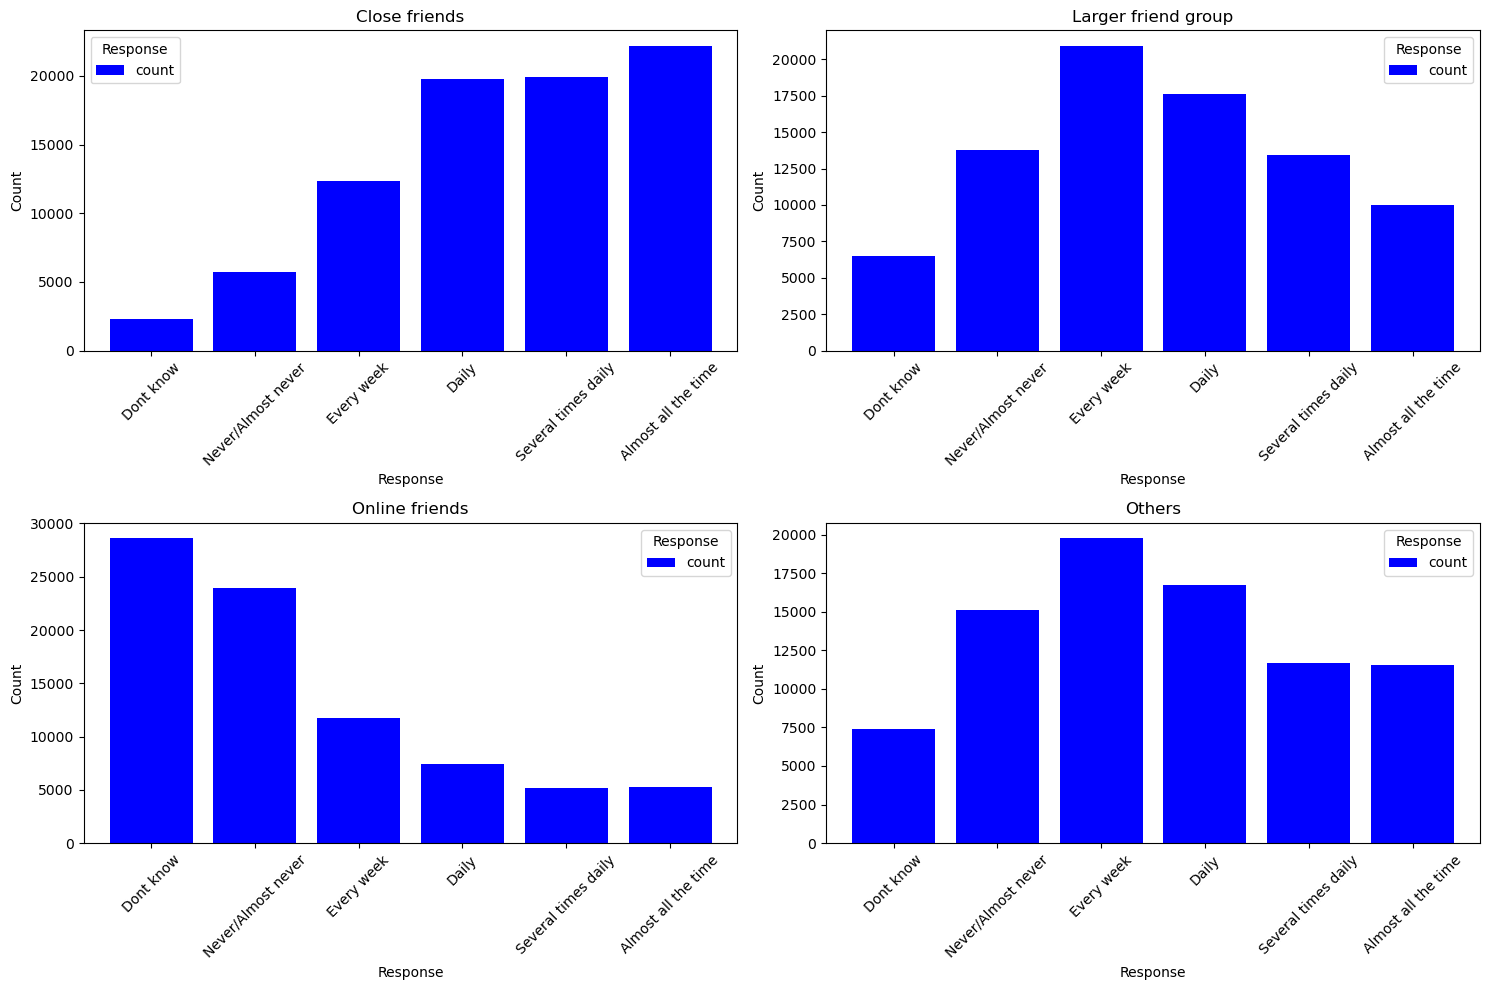

In [34]:
# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, (question, counts) in enumerate(tidy_emconlfreq_data.groupby("question")):
    counts["response"].value_counts().loc[replace_values.values()].plot(kind='bar', ax=axes[i // 2, i % 2], 
                                                                        color='blue', width=0.8)
    axes[i // 2, i % 2].set_title(question)
    axes[i // 2, i % 2].set_xlabel("Response")
    axes[i // 2, i % 2].set_ylabel("Count")
    axes[i // 2, i % 2].set_xticklabels(replace_values.values(), rotation=45)
    axes[i // 2, i % 2].legend(title="Response")

plt.tight_layout()
plt.show()

### 2.3 Visualizing emconlpref data 

In [35]:
emconlpref_data = hbsc_data_filtered[["emconlpref1", "emconlpref2", "emconlpref3"]]
emconlpref_data = emconlpref_data.rename(columns = {"emconlpref1": "Sharing secrets online", 
                                                    "emconlpref2": "Sharing feelings online",
                                                    "emconlpref3": "Sharing concerns online",
                                                    } ) 
 
replace_values = {1: "Strongly Disagree", 2: "Disagree", 3: "Neither/nor",
                  4: "Agree", 5: "Strongly Agree"}

# Restructuring dataframe to make it easier to graph 
tidy_emconlpref_data = emconlpref_data.reset_index(drop = True) 
tidy_emconlpref_data = emconlpref_data.melt(var_name = "question", value_name = "response") 
tidy_emconlpref_data["response"] = tidy_emconlpref_data["response"].replace(replace_values) 

tidy_emconlpref_data.head() 

,question,response
0,Sharing secrets online,Neither/nor
1,Sharing secrets online,Strongly Agree
2,Sharing secrets online,Agree
3,Sharing secrets online,Neither/nor
4,Sharing secrets online,Neither/nor


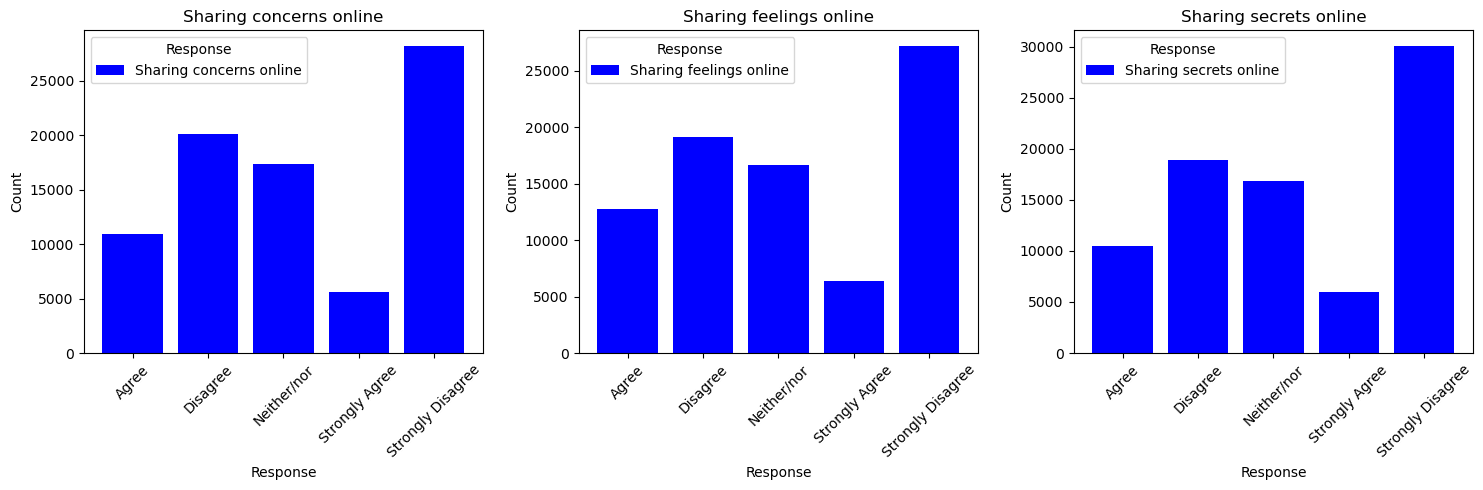

In [37]:
# Count the occurrences of each response for each question
response_counts = tidy_emconlpref_data.groupby(['question', 'response']).size().unstack(fill_value=0)


#Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (question, counts) in enumerate(response_counts.iterrows()):
    counts.plot(kind='bar', ax=axes[i], color='blue', width=0.8)
    axes[i].set_title(question)
    axes[i].set_xlabel("Response")
    axes[i].set_ylabel("Count")
    axes[i].set_xticklabels(response_counts.columns, rotation=45)
    axes[i].legend(title="Response")

plt.tight_layout()
plt.show()